<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
<center>Author: [Mariya Mansurova](https://www.linkedin.com/in/mariya-mansurova-04070982/), analyst & developer in Yandex.Metrics team. <br>Translated by [Ivan Zakharov](https://www.linkedin.com/in/ivan-zakharov/), ML enthusiast.
<br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [200]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


from itertools import product
from tqdm import tqdm_notebook


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

3.4.1


## Data preparation

In [56]:
df = pd.read_csv('../input/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [57]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [58]:
df.date = pd.to_datetime(df.date)

In [59]:
plotly_df(df.set_index('date')[['count']])

In [60]:
from fbprophet import Prophet

In [61]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426
- 5229
- 2744

In [62]:
train_df = df[:-predictions]
train_df.tail()

,ds,y
358,2015-12-17,2870
363,2015-12-18,2475
364,2015-12-19,1659
344,2015-12-20,1534
343,2015-12-21,2425


In [63]:
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=predictions)
future.tail()

forecast = m.predict(future)
forecast.tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2979.319903,1714.569167,2509.778915,2959.779663,2998.835152,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,0.0,0.0,0.0,2117.626592
379,2016-01-17,2984.727592,1892.336245,2695.708811,2963.784526,3005.307004,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,0.0,0.0,0.0,2264.022238
380,2016-01-18,2990.135281,2881.407750,3679.587681,2968.173206,3011.909696,281.357669,281.357669,281.357669,281.357669,281.357669,281.357669,0.0,0.0,0.0,3271.492950
381,2016-01-19,2995.542971,3145.150818,3959.207960,2972.109865,3018.978335,541.423837,541.423837,541.423837,541.423837,541.423837,541.423837,0.0,0.0,0.0,3536.966808
382,2016-01-20,3000.950660,2992.470610,3826.596663,2976.108146,3025.611656,425.547911,425.547911,425.547911,425.547911,425.547911,425.547911,0.0,0.0,0.0,3426.498570


In [64]:
round(forecast[forecast['ds']=='2016-01-20']['yhat'])

382    3426.0
Name: yhat, dtype: float64

Estimate the quality of the prediction with the last 30 points.

In [70]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [71]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2016-01-16,2117.626592,1714.569167,2509.778915,1644
2016-01-17,2264.022238,1892.336245,2695.708811,1836
2016-01-18,3271.492950,2881.407750,3679.587681,2983
2016-01-19,3536.966808,3145.150818,3959.207960,3389
2016-01-20,3426.498570,2992.470610,3826.596663,3559


In [69]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [72]:
calculate_forecast_errors(cmp_df, predictions)

{'MAPE': 34.502925740494526, 'MAE': 599.8383194732162}

**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600
- 903

## Predicting with ARIMA

In [231]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats
import statsmodels as sm

plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

Dickey-Fuller test: p=0.1073921962761209


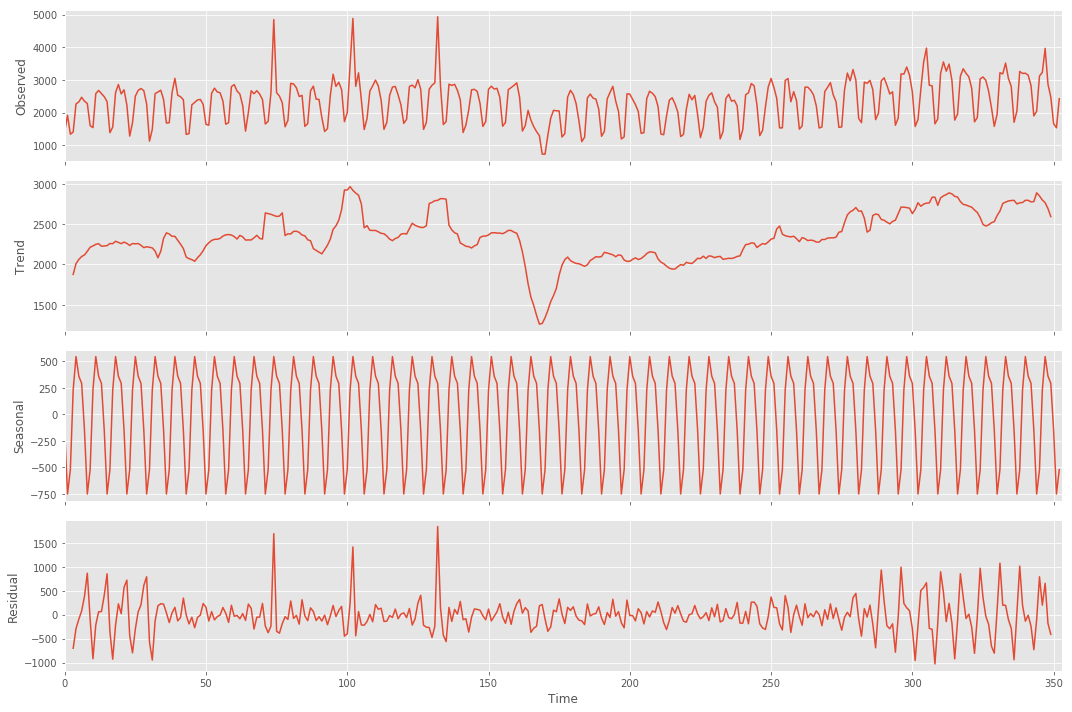

In [237]:
sm.tsa.seasonal.seasonal_decompose(train_df['y'].values, freq=7).plot();
print(f"Dickey-Fuller test: p={sm.tsa.stattools.adfuller(train_df['y'])[1]}")

In [84]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        sm.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

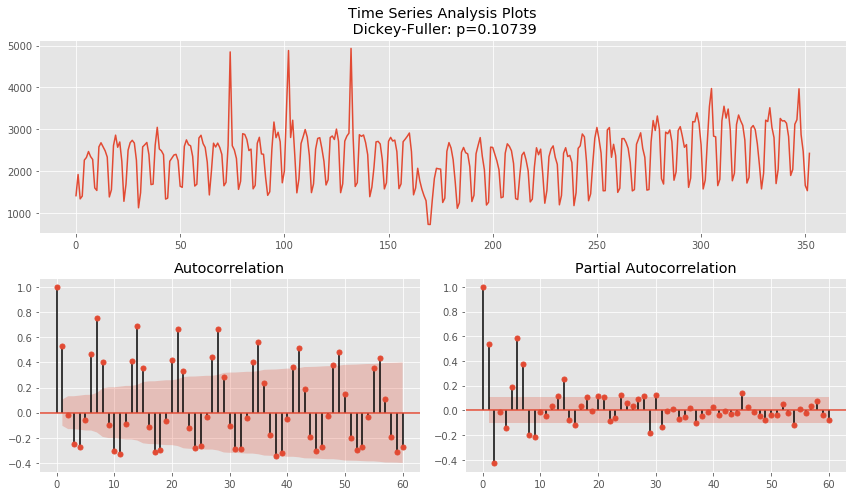

In [244]:
y = train_df['y']
tsplot(y.values, lags=60, style='ggplot')

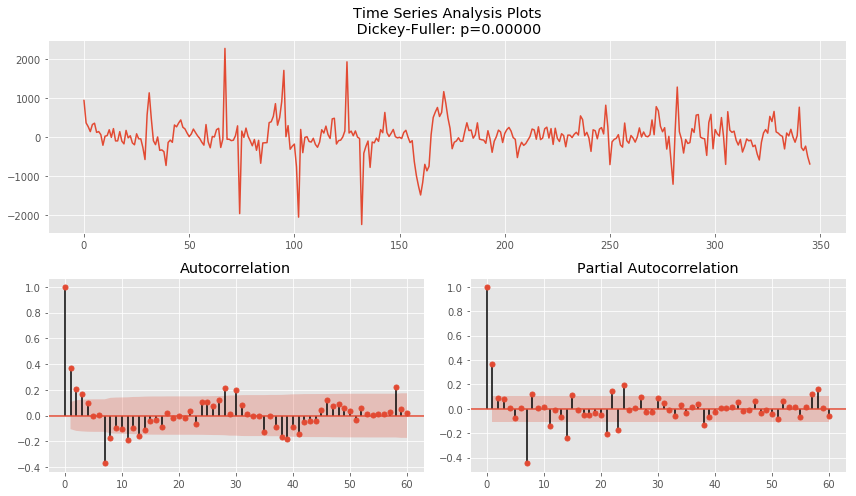

In [247]:
y_diff = y - y.shift(7)
tsplot(y_diff[7:].values, lags=60, style='ggplot')

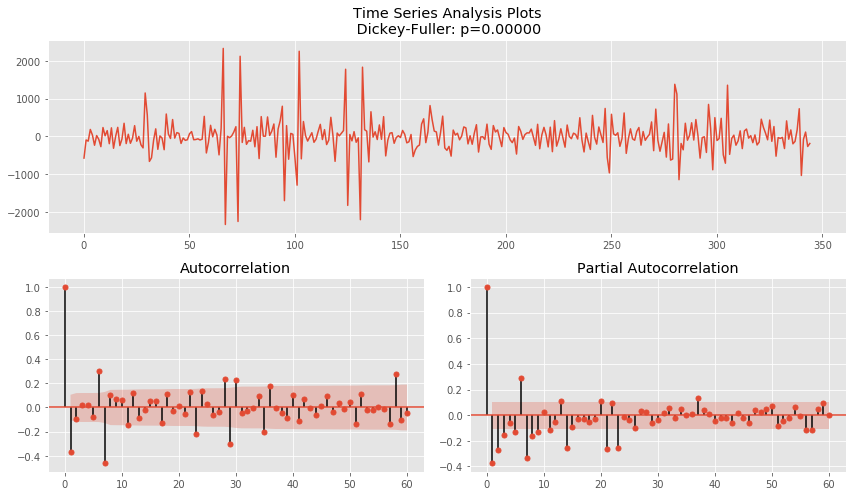

In [246]:
y_diff = y_diff - y_diff.shift(1)
tsplot(y_diff[7+1:].values, lags=60, style='ggplot')

**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [209]:
# setting initial values and some bounds for them
Ds = range(0, 3)
ds = range(0, 2)
Qs = range(0, 2)
q = 2
P = 3
p = 1

s = 7 # season length is still 7

# creating list with all the possible combinations of parameters
parameters = product(Ds, ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [215]:
def optimizeSARIMA(parameters_list, q, P, p, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (D, d, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        q - moving average model (ACF)
        Q - order of autoregression for the seasonal component of the model (ACF)
        p - The maximum lag in the model (PACF)
        P - order of autoregression for the seasonal component of the model (PACF)
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.sarimax.SARIMAX(y, order=(p, param[1], q), seasonal_order=(P, param[0], param[2], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
#     sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [248]:
%%time
result_table = optimizeSARIMA(parameters_list, q, P, p, s)


CPU times: user 2min 14s, sys: 1min 51s, total: 4min 5s
Wall time: 1min 3s


In [249]:
result_table.head()

,parameters,aic
0,"(2, 1, 1)",4988.979717
1,"(1, 1, 1)",5019.555903
2,"(1, 1, 0)",5019.904707
3,"(1, 0, 0)",5022.312524
4,"(1, 0, 1)",5022.982391


In [250]:
D, d, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.sarimax.SARIMAX(y, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(f'Best parameters: D={D}, d={d}, Q={Q}, q={q}, P={P}, p={p}')
print(best_model.summary())


Best parameters: D=2, d=1, Q=1, q=2, P=3, p=1
                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  353
Model:             SARIMAX(1, 1, 2)x(3, 2, 1, 7)   Log Likelihood               -2486.490
Date:                           Sun, 29 Nov 2020   AIC                           4988.980
Time:                                   14:25:49   BIC                           5019.564
Sample:                                        0   HQIC                          5001.169
                                           - 353                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9981      0.062    -16.171      0.000      -1.119      -0.8

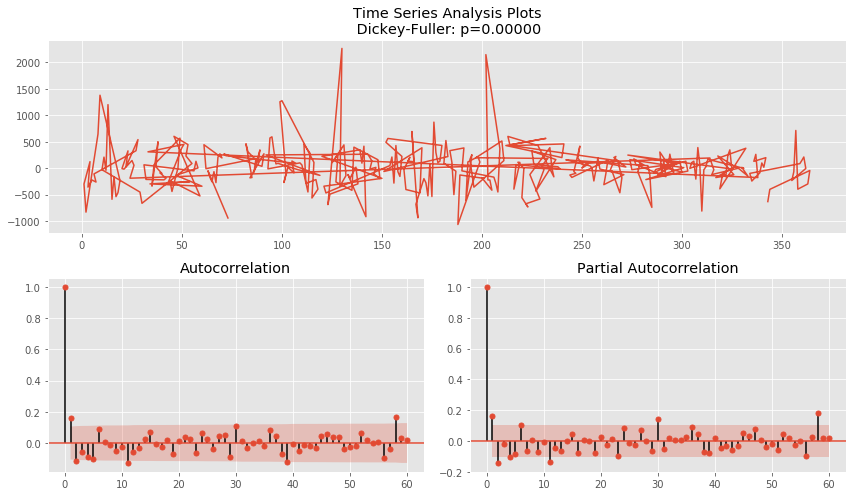

In [251]:
tsplot(best_model.resid[7+1:].values, lags=60, style='ggplot')